### Is the model able to generate correct answers based on the context provided?


In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import List, Optional
from langchain.chains.openai_tools import create_extraction_chain_pydantic
# from langchain_core.pydantic_v2 import BaseModel
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from typing import Literal, List
import pandas as pd
import numpy as np
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.language_models.chat_models import BaseChatModel
# import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

load_dotenv()


# - verify that llm is able to answer questions based on the context
# - veryfy that llm is able to generate a question based on the context
# - Is LLM able to automatically grade the students' answers?

# - some recommendation algorithms
# - pdf parser to text or markdown


True

Load SQUAD dataset

In [4]:
splits = {'train': 'plain_text/train-00000-of-00001.parquet', 'validation': 'plain_text/validation-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/rajpurkar/squad/" + splits["validation"])

Define dataclasses for the questions

In [ ]:
question_answer_template = ChatPromptTemplate([
    ("system", "Based on the following text, answer user's question, make the answer short and preceise while sticking to the context: {context}"),
    ("user", "{question}")
    ]
)

answer_validation_template = ChatPromptTemplate([
    ("system", "As an teacher, you are asked to validate the answer to the following question on a scale from 1 (completely incorrect) to 5 (excelent) The question is: {question}. The context is: {context}. Example correct answers with grade 5: {correct_answer}. Is this answer correct?"),
    ("user", "{answer}"),
    ("system", "Remember to output only the grade of the answer from 1 to 5 ONLY!")
    ]
)
question_generation_template = ChatPromptTemplate([
    ("system", "Based on the context given by user, generate a question that can be answered using the text: {context}"),
    ("user", "{context}")
    ]
)
class OpenEndedQuestion(BaseModel):
    question: str = Field(..., description="The question text.")
    example_correct_answers: List[str] = Field(
        ..., 
        description="Examples of correct answers to the question (can include multiple possible correct answers)."
    )
    context: str = Field(
        ..., 
        description="The context in which the question is being asked."
    )
    @classmethod
    def from_dataframe(cls, df: pd.DataFrame):
        questions = []
        for _, row in df.iterrows():
            question = cls(
                question=row['question'],
                example_correct_answers=row['answers']['text'],
                context=row['context']
            )
            questions.append(question)
        return questions

    def _generate_question_prompt_messages(self):
        return question_answer_template.format_messages(
            question=self.question, context=self.context
        )
    def _generate_question_prompt(self):
        return question_answer_template.invoke(
            {"question": self.question, "context": self.context}
        )
    
    def generate_llm_response(self, model: BaseChatModel):
        prompt = self._generate_question_prompt()
        response = model.invoke(prompt)
        return response

    def validate_answer(self, answer: str, model: BaseChatModel):
        # return any([answer.lower() == correct_answer.lower() for correct_answer in self.example_correct_answers])
        prompt = answer_validation_template.invoke(
            {"question": self.question, "context": self.context, "correct_answer": self.example_correct_answers, "answer": answer}
        )
        response = model(prompt)

        try:
            response = int(response.content)
            if response < 1 or response > 5:
                response = 0
        except ValueError:
            response = 0
        return response



    

Can generate the answer to the question based on the context provided?

In [ ]:
sample_df = df.sample(n=70, random_state=32)
open_ended_questions = OpenEndedQuestion.from_dataframe(sample_df)

llm = ChatOpenAI(temperature=0, model="gpt-4o-mini", api_key=os.getenv("OPEN_AI_KEY"))
llm_answer = open_ended_questions[0].generate_llm_response(llm)
llm_answer

Can LLM grade the answer to the question?

In [14]:
grade = open_ended_questions[0].validate_answer(llm_answer, llm)
grade


5

### Generate LLM Answers and Grade Them

In this section, we will generate answers to the questions using the LLM model and then grade these answers based on the provided context. Finally, we will plot the grades to visualize the performance of the LLM model.

We will use the `OpenEndedQuestion` class to generate answers and validate them. Then, we will plot the grades.


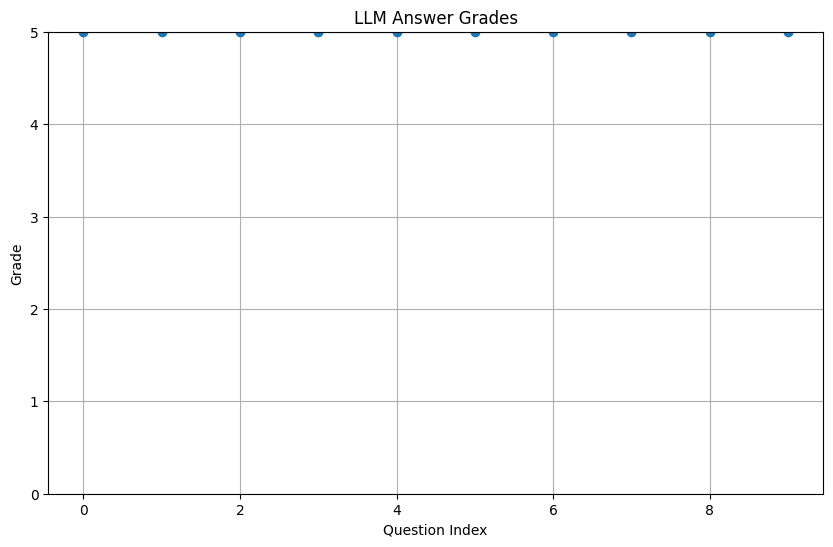

In [ ]:

# Generate answers and grades
grades = []
for question in open_ended_questions:
    llm_answer = question.generate_llm_response(llm)
    grade = question.validate_answer(llm_answer, llm)
    grades.append(grade)



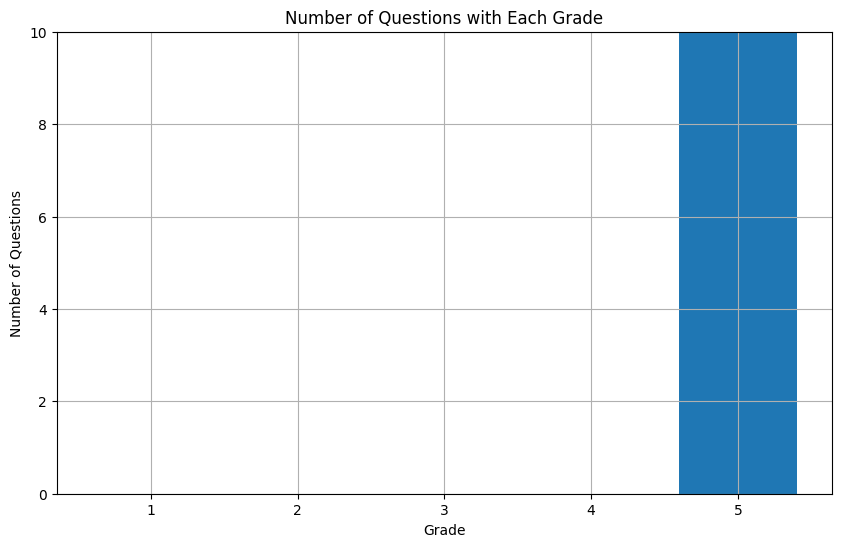

In [10]:
# Plot the grades using matplotlib as a bar plot
plt.figure(figsize=(10, 6))
plt.hist(grades, bins=range(1, 7), align='left', rwidth=0.8)
plt.title('Number of Questions with Each Grade')
plt.xlabel('Grade')
plt.ylabel('Number of Questions')
plt.xticks(range(1, 6))
plt.ylim(0, len(grades))
plt.grid(True)
plt.show()
